In [1]:
import numpy as np
import pandas as pd

loan_data = pd.read_csv('./loan.csv', header=0)

D:\Program Files (x86)\anaconda\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1. 样本选择

* 贷款数据集中含有80+万条贷款数据，占用内存500M，由于Python具有强大的处理能力，完全能够一次性处理500M数据，因此本文不对总体进行抽样，直接使用总体数据。
* 对于预测变量和表现变量的选择：本文使用信用局信用数据进行风险建模，因此只提取贷款用户的信用信息。

## 2. 模型分组

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import matplotlib
matplotlib.style.use('ggplot') 

Populating the interactive namespace from numpy and matplotlib


### 2.1 提取信用变量

参考FICO信用变量分组可知，变量可以划分为5个种类：
* 支付历史负面表现
* 信用历史
* 对新信用的追求程度
* 信用卡种类
* 现在的负债水平

In [3]:
payment_history = ['delinq_2yrs', 'mths_since_last_delinq', 'mths_since_last_record', 'pub_rec', 'collections_12_mths_ex_med', 'acc_now_delinq',\
                   'tot_coll_amt']
amount_of_debt = ['dti', 'revol_bal', 'revol_util', 'total_acc', 'tot_cur_bal', 'total_bal_il', 'il_util', 'max_bal_bc', 'all_util', \
                  'total_rev_hi_lim']
length_of_credit_history = ['earliest_cr_line']
new_credit = ['inq_last_6mths', 'open_acc', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', \
              'open_rv_12m', 'open_rv_24m', 'inq_fi', 'total_cu_tl']
credit_mix = []

credit_variable = []
credit_variable.extend(payment_history)
credit_variable.extend(amount_of_debt)
credit_variable.extend(length_of_credit_history)
credit_variable.extend(new_credit)
credit_variable.extend(credit_mix)
credit_data = loan_data[credit_variable]
credit_data.head()

,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,pub_rec,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,dti,revol_bal,revol_util,...,open_acc,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,open_rv_12m,open_rv_24m,inq_fi,total_cu_tl
0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,27.65,13648.0,83.7,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,0.0,0.0,0.0,NaN,1.00,1687.0,9.4,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,0.0,0.0,0.0,NaN,8.72,2956.0,98.5,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,35.0,NaN,0.0,0.0,0.0,NaN,20.00,5598.0,21.0,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,38.0,NaN,0.0,0.0,0.0,NaN,17.94,27783.0,53.9,...,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


从上表可以看出，数据当中有很多缺失值，这些缺失值可能是由于信用历史太短而没有记录所造成的缺失。而对于有完备信用记录的人群，我们所建的模型显然要和信用记录过少的人群有所不同。**因此，我们先按信用记录的多寡来对数据进行分组**

### 2.2 按信用记录多寡进行模型分组

In [4]:
null_data = credit_data.isnull().sum(0)
null_data = null_data[null_data > 0]
null_data.sort_values()

delinq_2yrs                       29
inq_last_6mths                    29
earliest_cr_line                  29
pub_rec                           29
acc_now_delinq                    29
total_acc                         29
open_acc                          29
collections_12_mths_ex_med       145
revol_util                       502
total_rev_hi_lim               70276
tot_cur_bal                    70276
tot_coll_amt                   70276
mths_since_last_delinq        454312
mths_since_last_record        750326
open_rv_12m                   866007
open_il_24m                   866007
open_il_12m                   866007
open_rv_24m                   866007
open_il_6m                    866007
all_util                      866007
inq_fi                        866007
max_bal_bc                    866007
total_bal_il                  866007
open_acc_6m                   866007
total_cu_tl                   866007
mths_since_rcnt_il            866569
il_util                       868762
d

#### 2.2.1 得到拥有完善信用记录的贷款者信用信息并建模

In [5]:
perfect_credit_data = credit_data[credit_data.il_util.notnull()]
perfect_credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18617 entries, 466285 to 489161
Data columns (total 29 columns):
delinq_2yrs                   18617 non-null float64
mths_since_last_delinq        9828 non-null float64
mths_since_last_record        3417 non-null float64
pub_rec                       18617 non-null float64
collections_12_mths_ex_med    18617 non-null float64
acc_now_delinq                18617 non-null float64
tot_coll_amt                  18617 non-null float64
dti                           18617 non-null float64
revol_bal                     18617 non-null float64
revol_util                    18606 non-null float64
total_acc                     18617 non-null float64
tot_cur_bal                   18617 non-null float64
total_bal_il                  18617 non-null float64
il_util                       18617 non-null float64
max_bal_bc                    18617 non-null float64
all_util                      18617 non-null float64
total_rev_hi_lim              18617 non

通过查看上表，可以发现：
* mths_since_last_delinq和mths_since_last_record两列缺失值太多，应当直接删除。
* revol_util和mths_since_rcnt_il两列缺失值不多，我们可以直接删除对应的缺失行即可。

In [6]:
perfect_credit_data = perfect_credit_data.drop(['mths_since_last_delinq', 'mths_since_last_record'], 1)
perfect_credit_data = perfect_credit_data.dropna()
perfect_credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18580 entries, 466285 to 489161
Data columns (total 27 columns):
delinq_2yrs                   18580 non-null float64
pub_rec                       18580 non-null float64
collections_12_mths_ex_med    18580 non-null float64
acc_now_delinq                18580 non-null float64
tot_coll_amt                  18580 non-null float64
dti                           18580 non-null float64
revol_bal                     18580 non-null float64
revol_util                    18580 non-null float64
total_acc                     18580 non-null float64
tot_cur_bal                   18580 non-null float64
total_bal_il                  18580 non-null float64
il_util                       18580 non-null float64
max_bal_bc                    18580 non-null float64
all_util                      18580 non-null float64
total_rev_hi_lim              18580 non-null float64
earliest_cr_line              18580 non-null object
inq_last_6mths                18580 no

In [7]:
perfect_credit_data.head()

,delinq_2yrs,pub_rec,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,dti,revol_bal,revol_util,total_acc,tot_cur_bal,...,open_acc,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,open_rv_12m,open_rv_24m,inq_fi,total_cu_tl
466285,0.0,0.0,0.0,0.0,321.0,6.46,14277.0,27.4,46.0,146867.0,...,17.0,1.0,11.0,0.0,0.0,28.0,0.0,1.0,1.0,4.0
466286,0.0,0.0,0.0,0.0,0.0,7.28,7158.0,26.7,24.0,165450.0,...,15.0,0.0,1.0,1.0,1.0,11.0,0.0,3.0,1.0,0.0
466287,2.0,0.0,0.0,0.0,0.0,15.22,1058.0,24.6,6.0,4888.0,...,6.0,0.0,1.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0
466288,0.0,0.0,0.0,0.0,0.0,31.04,5812.0,40.9,23.0,41166.0,...,10.0,1.0,3.0,0.0,2.0,13.0,1.0,1.0,1.0,1.0
466289,0.0,0.0,0.0,0.0,0.0,10.78,7869.0,56.2,18.0,189699.0,...,6.0,0.0,1.0,0.0,4.0,19.0,0.0,2.0,2.0,5.0


In [8]:
# 通过earliest_cr_line得到贷款者信用历史长度
perfect_credit_data['earliest_cr_line'] = pd.to_datetime(perfect_credit_data.earliest_cr_line)
perfect_credit_data.earliest_cr_line.head()

466285   1990-02-01
466286   2001-07-01
466287   2011-07-01
466288   1998-12-01
466289   2000-08-01
Name: earliest_cr_line, dtype: datetime64[ns]

In [9]:
time_now = datetime.datetime(2015, 9, 9)
perfect_credit_data['credit_history_length'] = perfect_credit_data.earliest_cr_line
perfect_credit_data['credit_history_length'] = time_now - perfect_credit_data.earliest_cr_line
perfect_credit_data.credit_history_length.head()

466285   9351 days
466286   5183 days
466287   1531 days
466288   6126 days
466289   5517 days
Name: credit_history_length, dtype: timedelta64[ns]

In [10]:
perfect_credit_data['credit_history_length'] = perfect_credit_data.credit_history_length.map(lambda x: float(x.days/360))
perfect_credit_data[['credit_history_length', 'earliest_cr_line']].head()

,credit_history_length,earliest_cr_line
466285,25.0,1990-02-01
466286,14.0,2001-07-01
466287,4.0,2011-07-01
466288,17.0,1998-12-01
466289,15.0,2000-08-01


**1）按信用历史对模型进行分组**

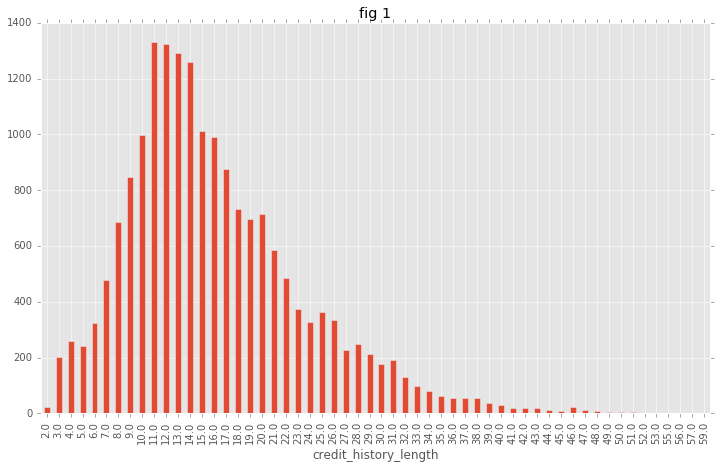

In [11]:
perfect_credit_data[['credit_history_length']].groupby('credit_history_length').credit_history_length.agg(np.count_nonzero).plot(kind='bar', figsize=(12, 7), title='fig 1')

**2）按信用历史分组统计“坏”的频率，评估是否需要按信用历史长度对模型分组**

“坏”的定义（参考《信用评分模型技术与应用》P118）：
* 个人破产
* 呆账（这是啥玩意？）
* 贷款违约
* 抵押品拘押
* 严重逾期拖欠

 以上“坏”的表现可用变量：collections_12_mths_ex_med、acc_now_delinq、tot_coll_amt来确定。

“好”的定义：
* 未出现违约和拖欠行为
* 30天以下的轻度拖欠行为

In [12]:
perfect_credit_data.tot_coll_amt.describe()

count     18580.000000
mean        278.944618
std        2280.580472
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      140842.000000
Name: tot_coll_amt, dtype: float64

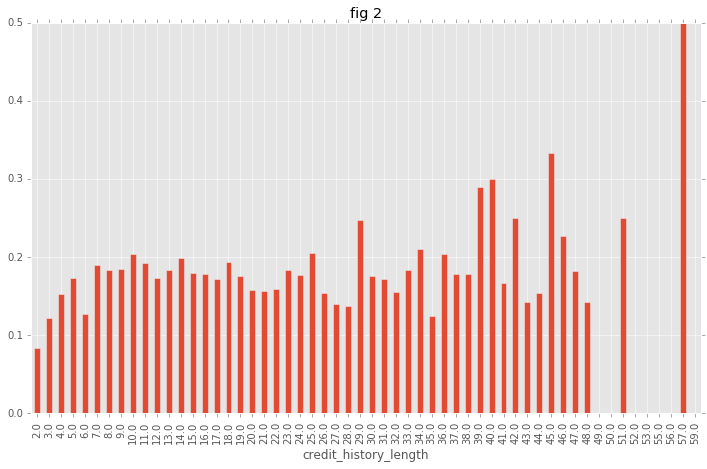

In [13]:
perfect_credit_data['unhealthy'] = -1
perfect_credit_data.unhealthy = ((perfect_credit_data.collections_12_mths_ex_med > 0) | (perfect_credit_data.acc_now_delinq > 0) | (perfect_credit_data.tot_coll_amt > 0)).astype(np.int)
perfect_credit_data['credit_history_length_string'] = perfect_credit_data.credit_history_length.astype(np.str)
perfect_credit_data[['credit_history_length', 'unhealthy']].groupby('credit_history_length').unhealthy.agg(np.mean).plot(kind='bar', figsize=(12, 7), title='fig 2')

从上图可以看出，在信用信息完善的贷款者样本当中，违约率和信用历史长短没有明显的正相关或负相关关系。**因此我们不能按信用历史对模型进行分组。**

那么接下来我们就需要探究哪个变量适合对模型进行分组，参考《信用评分模型技术与应用》P101可以知道，银行一般都是按信用历史长度以及还款历史对模型进行分组，那么我们来探究探究还款历史变量吧。

In [20]:
payment_history.remove('mths_since_last_delinq')
payment_history.remove('mths_since_last_record')

credit_variable.remove('mths_since_last_delinq')
credit_variable.remove('mths_since_last_record')

for var in payment_history:
    print "%s: %s" %(var, perfect_credit_data[var].unique())

delinq_2yrs: [  0.   2.   1.   3.   4.   6.   5.  15.   7.   9.  10.   8.  11.  13.]
pub_rec: [  0.   2.   1.   3.   5.   4.  11.   7.   6.   9.   8.  10.  23.]
collections_12_mths_ex_med: [ 0.  1.  2.  3.  4.]
acc_now_delinq: [ 0.  1.  2.]
tot_coll_amt: [   321.      0.    722. ...,   2766.   1303.  16467.]


In [15]:
import seaborn as sns

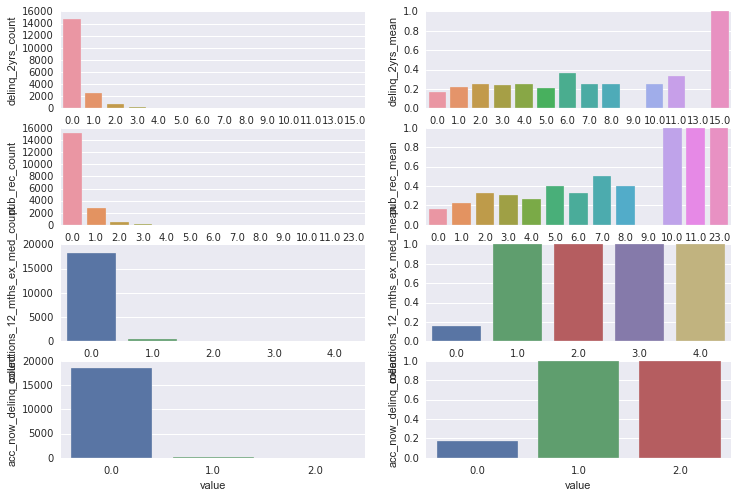

In [16]:
def plot_count_mean(variables, fig_size=(12, 8)):
    var_need = len(variables)
    f, ax_array = plt.subplots(var_need, 2)
    f.set_size_inches(fig_size[0], fig_size[1])
    for index in range(0, var_need):
        var = variables[index]
        # 绘制分组计数图
        var_count = pd.value_counts(perfect_credit_data[var]).to_frame().reset_index()
        var_count.columns = ['value', 'count']
        sns.barplot(y='count', x='value', data=var_count, ax=ax_array[index][0])
        ax_array[index][0].set(ylabel=var+'_count')
        # 绘制分组违约率图
        var_mean = perfect_credit_data[[var, 'unhealthy']].groupby(var).unhealthy.agg(np.mean).to_frame().reset_index()
        var_mean.columns = ['value', 'mean']
        sns.barplot(y='mean', x='value', data=var_mean, ax=ax_array[index][1])
        ax_array[index][1].set(ylabel=var+'_mean')
plot_count_mean(payment_history[0:(len(payment_history)-1)])

In [18]:
print perfect_credit_data.unhealthy.sum()
print perfect_credit_data.unhealthy.sum()/float(len(perfect_credit_data.unhealthy))

3334
0.179440258342


***<u>在此忽略了一个重要因素：违约总数不多，只有3334条违约记录，而总数18万条，违约率为17.9%。我们没必要再进行分组建模了，否则适得其反。</u>***

**3）对预测变量进行栏位划分**
* 了解每个预测变量得性质，是连续型还是标称型
* 对每个连续型变量进行栏位划分
* 对标称型变量验证是否还需进行栏位划分

In [21]:
print "%-29s %-20s" %("变量", "唯一值个数")
for var in credit_variable:
    unique_value = perfect_credit_data[var].unique()
    print "%-29s %-20s" %(var, len(unique_value))

变量                        唯一值个数     
delinq_2yrs                   14                  
pub_rec                       13                  
collections_12_mths_ex_med    5                   
acc_now_delinq                3                   
tot_coll_amt                  1513                
dti                           3567                
revol_bal                     14237               
revol_util                    1040                
total_acc                     88                  
tot_cur_bal                   17888               
total_bal_il                  16491               
il_util                       1272                
max_bal_bc                    9861                
all_util                      1052                
total_rev_hi_lim              1948                
earliest_cr_line              537                 
inq_last_6mths                6                   
open_acc                      51                  
open_acc_6m                   13             

In [22]:
short_var = []
long_var = []
for var in credit_variable:
    len_var = len(perfect_credit_data[var].unique())
    if len_var < 16:
        short_var.append(var)
    else:
        long_var.append(var)
print short_var
print long_var

['delinq_2yrs', 'pub_rec', 'collections_12_mths_ex_med', 'acc_now_delinq', 'inq_last_6mths', 'open_acc_6m', 'open_il_12m']
['tot_coll_amt', 'dti', 'revol_bal', 'revol_util', 'total_acc', 'tot_cur_bal', 'total_bal_il', 'il_util', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'earliest_cr_line', 'open_acc', 'open_il_6m', 'open_il_24m', 'mths_since_rcnt_il', 'open_rv_12m', 'open_rv_24m', 'inq_fi', 'total_cu_tl']


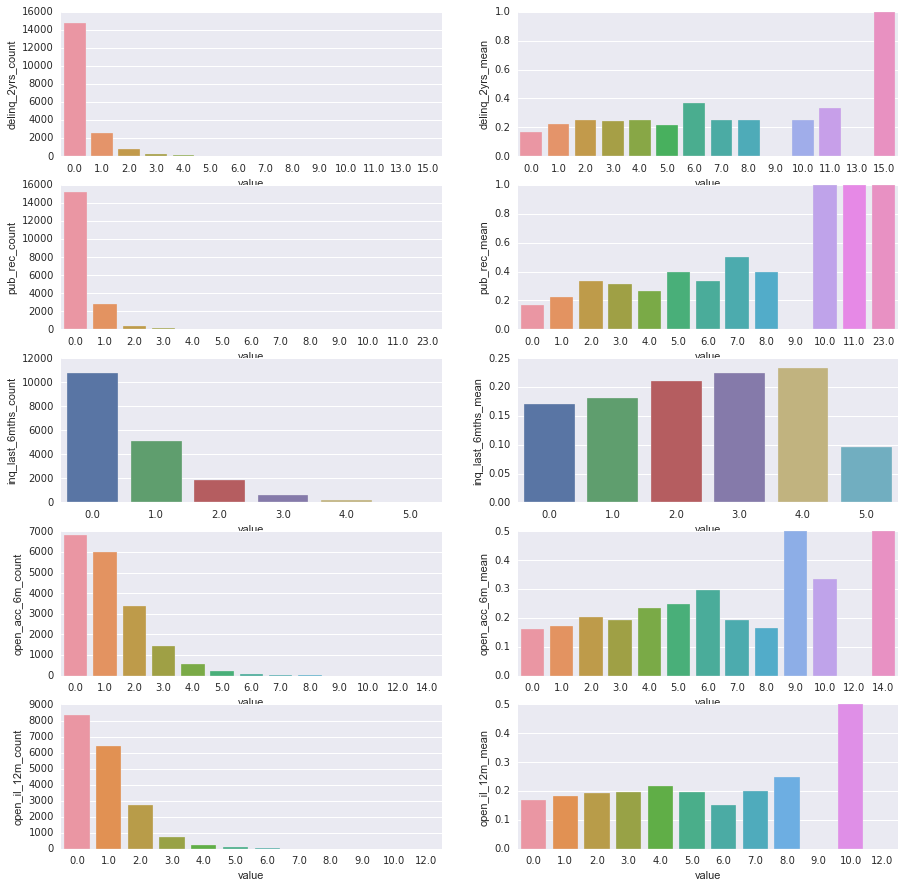

In [23]:
# 删除表现变量
short_var.remove('collections_12_mths_ex_med')
short_var.remove('acc_now_delinq')
long_var.remove('tot_coll_amt')
plot_count_mean(short_var, fig_size=(15, 15))

根据上图，对short_var中的变量进行如下栏位划分：

| 变量       |  分组      |
| ------------- | -------------|
| delinq_2yrs  | [0, 1, 4, 6, 9, 16] |
|  pub_rec    | [0, 2, 6, 9, 25]    |
| inq_last_6mths |[0, 1, 2, 3, 4, 5, 6] |
| open_acc_6m   |[0, 3, 7, 15]  |
| open_il_12m   |[0, 2, 4, 9, 13]    |

In [24]:
partition_percent_of_short_var = pd.DataFrame(-1, columns=short_var, index=[0, 1, 2, 3, 4, 5, 6])
partition_percent_of_short_var[short_var[0]] = pd.Series([0, 1, 4, 6, 9, 16])
partition_percent_of_short_var[short_var[1]] = pd.Series([0, 2, 6, 9, 25])
partition_percent_of_short_var[short_var[2]] = pd.Series([0, 1, 2, 3, 4, 5, 6])
partition_percent_of_short_var[short_var[3]] = pd.Series([0, 3, 7, 15])
partition_percent_of_short_var[short_var[4]] = pd.Series([0, 2, 4, 9, 13])
partition_percent_of_short_var

,delinq_2yrs,pub_rec,inq_last_6mths,open_acc_6m,open_il_12m
0,0.0,0.0,0,0.0,0.0
1,1.0,2.0,1,3.0,2.0
2,4.0,6.0,2,7.0,4.0
3,6.0,9.0,3,15.0,9.0
4,9.0,25.0,4,NaN,13.0
5,16.0,NaN,5,NaN,NaN
6,NaN,NaN,6,NaN,NaN


In [25]:
long_var.remove('earliest_cr_line')
credit_variable.remove('earliest_cr_line')
perfect_credit_data[long_var].describe()

,dti,revol_bal,revol_util,total_acc,tot_cur_bal,total_bal_il,il_util,max_bal_bc,all_util,total_rev_hi_lim,open_acc,open_il_6m,open_il_24m,mths_since_rcnt_il,open_rv_12m,open_rv_24m,inq_fi,total_cu_tl
count,18580.000000,18580.00000,18580.000000,18580.000000,1.858000e+04,18580.000000,18580.000000,18580.000000,18580.000000,18580.000000,18580.000000,18580.000000,18580.000000,18580.000000,18580.000000,18580.000000,18580.000000,18580.000000
mean,21.032587,17278.16211,51.879435,26.388590,1.475376e+05,40223.423197,71.639150,5821.181109,62.477944,34411.630194,12.559365,3.327126,1.870560,16.056351,1.390743,2.985953,0.995210,1.645802
std,74.109002,22476.39776,24.145574,12.202338,1.534772e+05,43386.172628,22.886046,5155.926895,18.685006,33833.530691,5.797893,3.115428,1.692518,18.686639,1.521385,2.614135,1.472473,2.821034
min,0.000000,0.00000,0.000000,4.000000,4.760000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.060000,6235.00000,33.800000,18.000000,3.585975e+04,14076.500000,58.700000,2404.000000,49.900000,14600.000000,8.000000,1.000000,1.000000,5.000000,0.000000,1.000000,0.000000,0.000000
50%,19.870000,11807.00000,51.700000,25.000000,9.121900e+04,27559.500000,75.000000,4464.000000,63.100000,25500.000000,11.000000,2.000000,1.000000,11.000000,1.000000,2.000000,0.000000,0.000000
75%,26.360000,21077.50000,70.325000,33.000000,2.179302e+05,51067.250000,87.700000,7677.500000,75.800000,42900.000000,16.000000,4.000000,3.000000,19.000000,2.000000,4.000000,1.000000,2.000000
max,9999.000000,647310.00000,134.300000,111.000000,2.004106e+06,878459.000000,223.300000,127305.000000,151.400000,755900.000000,65.000000,40.000000,19.000000,363.000000,22.000000,43.000000,16.000000,35.000000


***连续型变量该怎么进行栏位划分呢？***
初步想法是利用四分位数。

In [26]:
def group_value(long_var_field, long_variables):
    four_percent = perfect_credit_data[long_variables].describe()[3::]
    for var in long_variables:
        field_var = var+'_field'
        long_var_field.append(field_var)
        four_percent_var = four_percent[var].values
        perfect_credit_data[field_var] = 0
        for i in range(0, 4):
            perfect_credit_data.loc[(perfect_credit_data[var] >= four_percent_var[i]) & (perfect_credit_data[var] < four_percent_var[i+1]), \
                                   field_var] = (four_percent_var[i] + four_percent_var[i+1])/2
            if four_percent_var[i] == four_percent_var[i+1]:
                perfect_credit_data.loc[(perfect_credit_data[var] == four_percent_var[i]), field_var] = four_percent_var[i]

long_var_of_field = []
group_value(long_var_of_field, long_var)
perfect_credit_data[['dti', 'dti_field']].head()

,dti,dti_field
466285,6.46,7.030
466286,7.28,7.030
466287,15.22,16.965
466288,31.04,5012.680
466289,10.78,7.030


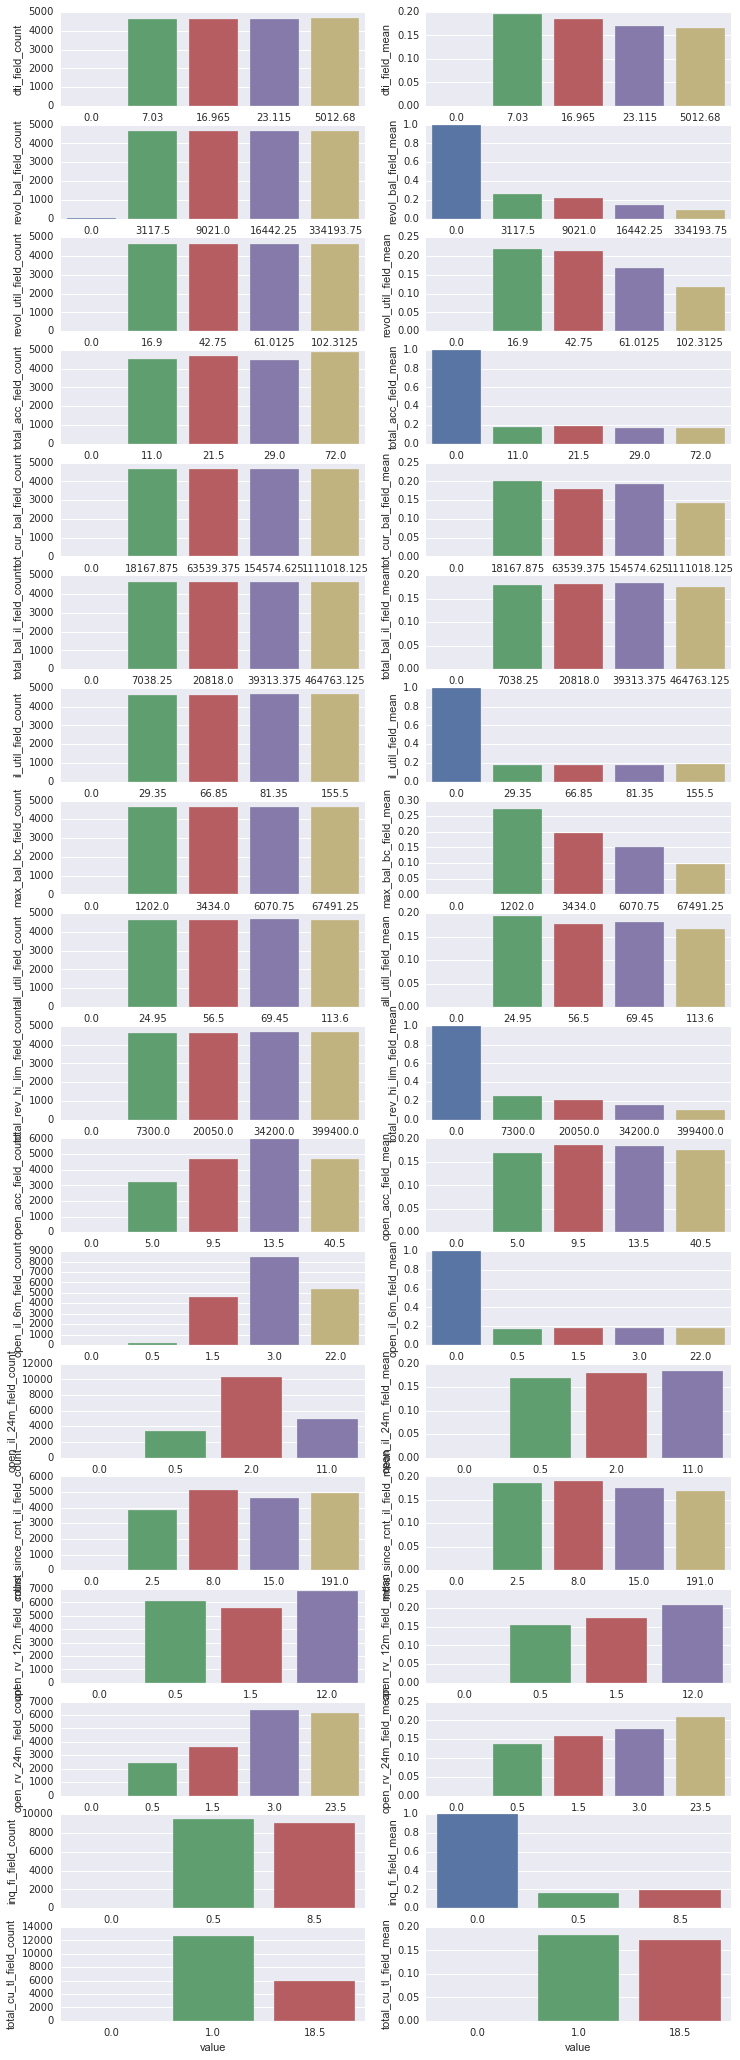

In [27]:
plot_count_mean(long_var_of_field, fig_size=(12, 36))

根据上图可以看出，对于所有的long_var中的变量，直接使用四分位数进行栏位划分即可。当然，在图中，也展示了某些变量对违约率的预测效果并不明显，可以直接删除，这些变量为：total_acc_field、total_bal_il_field、il_util_field以及open_il_6m_field。

In [29]:
amount_of_debt.remove('total_acc')
amount_of_debt.remove('il_util')
amount_of_debt.remove('total_bal_il')
new_credit.remove('open_il_6m')

long_var_of_field.remove('total_acc_field')
long_var_of_field.remove('total_bal_il_field')
long_var_of_field.remove('il_util_field')
long_var_of_field.remove('open_il_6m_field')

long_var.remove('total_acc')
long_var.remove('total_bal_il')
long_var.remove('il_util')
long_var.remove('open_il_6m')

perfect_credit_data.drop(['total_acc', 'total_bal_il', 'il_util', 'open_il_6m'], 1, inplace=True)
perfect_credit_data.drop(['total_acc_field', 'total_bal_il_field', 'il_util_field', 'open_il_6m_field'], 1, inplace=True)

In [30]:
partition_percent_of_long_var = pd.DataFrame(perfect_credit_data[long_var].describe()[3::], columns=long_var)
partition_percent_of_long_var.index=[0, 1, 2, 3, 4]
partition_percent_of_long_var

,dti,revol_bal,revol_util,tot_cur_bal,max_bal_bc,all_util,total_rev_hi_lim,open_acc,open_il_24m,mths_since_rcnt_il,open_rv_12m,open_rv_24m,inq_fi,total_cu_tl
0,0.00,0.0,0.000,476.00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.06,6235.0,33.800,35859.75,2404.0,49.9,14600.0,8.0,1.0,5.0,0.0,1.0,0.0,0.0
2,19.87,11807.0,51.700,91219.00,4464.0,63.1,25500.0,11.0,1.0,11.0,1.0,2.0,0.0,0.0
3,26.36,21077.5,70.325,217930.25,7677.5,75.8,42900.0,16.0,3.0,19.0,2.0,4.0,1.0,2.0
4,9999.00,647310.0,134.300,2004106.00,127305.0,151.4,755900.0,65.0,19.0,363.0,22.0,43.0,16.0,35.0


从上图也可以看出，有些变量根据四分位数划分导致栏位过少，这些变量是：['open_il_24m', 'inq_fi', 'total_cu_tl']。那么我们应该重新划分栏位。

In [226]:
partition_percent_of_long_var.drop('open_il_24m', 1, inplace=True)
partition_percent_of_long_var.drop('inq_fi', 1, inplace=True)
partition_percent_of_long_var.drop('total_cu_tl', 1, inplace=True)

In [31]:
re_partiton_var = ['open_il_24m', 'inq_fi', 'total_cu_tl']
for var in re_partiton_var:
    long_var.remove(var)
    long_var_of_field.remove(var+'_field')

In [33]:
partition_percent = pd.DataFrame(0, columns=re_partiton_var, index=['0', '1', '2', '3', '4'])
for i in range(0, len(re_partiton_var)):
    max_value = perfect_credit_data[re_partiton_var[i]].describe()[-1]
    partition_percent[re_partiton_var[i]] = pd.Series([0, max_value/16, max_value/8, max_value/4, max_value]).values
partition_percent

,open_il_24m,inq_fi,total_cu_tl
0,0.0000,0.0,0.0000
1,1.1875,1.0,2.1875
2,2.3750,2.0,4.3750
3,4.7500,4.0,8.7500
4,19.0000,16.0,35.0000


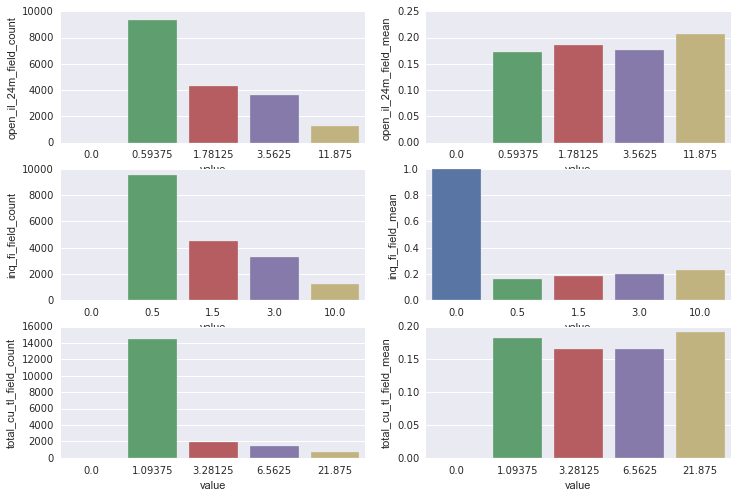

In [34]:
def re_group_value(re_partiton_var_of_field, re_partiton_var, partition_percent):
    for var in re_partiton_var:
        field_var = var+'_field'
        re_partiton_var_of_field.append(field_var)
        four_percent_var = partition_percent[var].values
        perfect_credit_data[field_var] = 0
        for i in range(0, 4):
            perfect_credit_data.loc[(perfect_credit_data[var] >= four_percent_var[i]) & (perfect_credit_data[var] < four_percent_var[i+1]), \
                                   field_var] = (four_percent_var[i] + four_percent_var[i+1])/2
            if four_percent_var[i] == four_percent_var[i+1]:
                perfect_credit_data.loc[(perfect_credit_data[var] == four_percent_var[i]), field_var] = four_percent_var[i]

re_partiton_var_of_field = []
re_group_value(re_partiton_var_of_field, re_partiton_var, partition_percent)
plot_count_mean(re_partiton_var_of_field)

根据上图，删除预测效果不好的变量。

In [35]:
for i in range(0, 2):
    tmp = re_partiton_var[0]
    re_partiton_var.remove(tmp)
    re_partiton_var_of_field.remove(tmp+'_field')

print re_partiton_var
print re_partiton_var_of_field

['total_cu_tl']
['total_cu_tl_field']


In [36]:
partition_percent_of_re_partiton_var = pd.DataFrame(partition_percent[re_partiton_var], columns=re_partiton_var)
partition_percent_of_re_partiton_var

,total_cu_tl
0,0.0000
1,2.1875
2,4.3750
3,8.7500
4,35.0000


**4）计算栏位划分之后各变量的WOE值**

In [37]:
def compute_woe(variables_woe, variables, partition_percent):
    unhealthy_percent_of_not_partition = perfect_credit_data.unhealthy.mean()
    unhealthy_divide_healthy_of_not_partition = unhealthy_percent_of_not_partition / (1-unhealthy_percent_of_not_partition)
    for var in variables:
        # 创建woe变量
        var_woe = var+'_woe'
        variables_woe.append(var_woe)
        # 为woe变量赋值
        perfect_credit_data[var_woe] = 0
        partition_percent_of_var = partition_percent[var].dropna().values
        for index in range(0, len(partition_percent_of_var)-1):
            where_clause = (perfect_credit_data[var] >= partition_percent_of_var[index]) & (perfect_credit_data[var] < partition_percent_of_var[index+1])
            unhealthy_mean = perfect_credit_data.loc[where_clause, 'unhealthy'].mean()
            if unhealthy_mean == 1:
                perfect_credit_data.loc[where_clause, var_woe] = 99999
            else:
                unhealthy_divide_healthy = unhealthy_mean / (1-unhealthy_mean)
                woe_not_ln = unhealthy_divide_healthy/unhealthy_divide_healthy_of_not_partition
                if woe_not_ln != 0:
                    perfect_credit_data.loc[where_clause, var_woe] = math.log(woe_not_ln, e)
                else:
                    perfect_credit_data.loc[where_clause, var_woe] = -1

            
short_var_woe = []
compute_woe(short_var_woe, short_var, partition_percent_of_short_var)

long_var_woe = []
compute_woe(long_var_woe, long_var, partition_percent_of_long_var)

re_partiton_var_woe = []
compute_woe(re_partiton_var_woe, re_partiton_var, partition_percent_of_re_partiton_var)

In [38]:
perfect_credit_data[short_var+short_var_woe].head(10)

,delinq_2yrs,pub_rec,inq_last_6mths,open_acc_6m,open_il_12m,delinq_2yrs_woe,pub_rec_woe,inq_last_6mths_woe,open_acc_6m_woe,open_il_12m_woe
466285,0.0,0.0,0.0,1.0,0.0,-0.095504,-0.035777,-0.060865,-0.034067,-0.027846
466286,0.0,0.0,0.0,0.0,1.0,-0.095504,-0.035777,-0.060865,-0.034067,-0.027846
466287,2.0,0.0,0.0,0.0,0.0,0.312291,-0.035777,-0.060865,-0.034067,-0.027846
466288,0.0,0.0,1.0,1.0,0.0,-0.095504,-0.035777,0.007813,-0.034067,-0.027846
466289,0.0,0.0,0.0,0.0,0.0,-0.095504,-0.035777,-0.060865,-0.034067,-0.027846
466290,0.0,2.0,1.0,0.0,2.0,-0.095504,0.792081,0.007813,-0.034067,0.094644
466291,0.0,0.0,1.0,0.0,0.0,-0.095504,-0.035777,0.007813,-0.034067,-0.027846
466292,0.0,0.0,1.0,2.0,0.0,-0.095504,-0.035777,0.007813,-0.034067,-0.027846
466293,0.0,0.0,0.0,0.0,0.0,-0.095504,-0.035777,-0.060865,-0.034067,-0.027846
466295,0.0,0.0,1.0,0.0,0.0,-0.095504,-0.035777,0.007813,-0.034067,-0.027846


In [39]:
perfect_credit_data[long_var+long_var_woe].head(10)

,dti,revol_bal,revol_util,tot_cur_bal,max_bal_bc,all_util,total_rev_hi_lim,open_acc,mths_since_rcnt_il,open_rv_12m,...,revol_bal_woe,revol_util_woe,tot_cur_bal_woe,max_bal_bc_woe,all_util_woe,total_rev_hi_lim_woe,open_acc_woe,mths_since_rcnt_il_woe,open_rv_12m_woe,open_rv_24m_woe
466285,6.46,14277.0,27.4,146867.0,5020.0,40.1,52200.0,17.0,28.0,0.0,...,-0.260358,0.246428,0.092984,-0.211423,0.089277,-0.616201,-0.032380,-0.074801,-0.182672,-0.154593
466286,7.28,7158.0,26.7,165450.0,3081.0,57.9,26800.0,15.0,11.0,0.0,...,0.233148,0.246428,0.092984,0.115441,-0.016446,-0.138020,0.034111,-0.027993,-0.182672,-0.008101
466287,15.22,1058.0,24.6,4888.0,367.0,22.4,4300.0,6.0,47.0,0.0,...,0.484556,0.246428,0.144580,0.534375,0.089277,0.407977,-0.078535,-0.074801,-0.182672,-0.316417
466288,31.04,5812.0,40.9,41166.0,3118.0,67.4,14200.0,10.0,13.0,1.0,...,0.484556,0.220221,0.002192,0.115441,0.011100,0.407977,0.040267,-0.027993,-0.047740,-0.154593
466289,10.78,7869.0,56.2,189699.0,2081.0,64.7,14000.0,6.0,19.0,0.0,...,0.233148,-0.086980,0.092984,0.534375,0.011100,0.407977,-0.078535,-0.074801,-0.182672,-0.008101
466290,13.89,12703.0,35.2,312996.0,7045.0,41.5,36100.0,7.0,8.0,1.0,...,-0.260358,0.220221,-0.272369,-0.211423,0.089277,-0.138020,-0.078535,0.065712,-0.047740,-0.154593
466291,26.02,20862.0,54.3,305781.0,8937.0,56.5,38400.0,9.0,13.0,0.0,...,-0.260358,-0.086980,-0.272369,-0.692487,-0.016446,-0.138020,0.040267,-0.027993,-0.182672,-0.154593
466292,5.91,2765.0,29.7,144904.0,722.0,33.6,9300.0,7.0,21.0,3.0,...,0.484556,0.246428,0.092984,0.534375,0.089277,0.407977,-0.078535,-0.074801,0.181491,-0.008101
466293,10.20,8822.0,68.4,12798.0,4522.0,75.7,12900.0,5.0,338.0,0.0,...,0.233148,-0.086980,0.144580,-0.211423,0.011100,0.407977,-0.078535,-0.074801,-0.182672,-0.316417
466295,10.24,3454.0,10.3,127412.0,3309.0,7.3,33600.0,9.0,73.0,0.0,...,0.484556,0.246428,0.092984,0.115441,0.089277,-0.138020,0.040267,-0.074801,-0.182672,-0.154593


In [40]:
perfect_credit_data[re_partiton_var_woe+re_partiton_var].head(10)

,total_cu_tl_woe,total_cu_tl
466285,-0.092319,4.0
466286,0.018434,0.0
466287,0.018434,0.0
466288,0.018434,1.0
466289,-0.100566,5.0
466290,-0.092319,3.0
466291,0.018434,0.0
466292,0.018434,1.0
466293,0.018434,0.0
466295,0.018434,0.0


**5）逻辑回归模拟**

In [41]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [73]:
train_data = perfect_credit_data[short_var_woe+long_var_woe+re_partiton_var_woe][0:len(perfect_credit_data)/2]
train_target = perfect_credit_data['unhealthy'][0:len(perfect_credit_data)/2]

test_data = perfect_credit_data[short_var_woe+long_var_woe+re_partiton_var_woe][(len(perfect_credit_data)/2+1)::]
test_target = perfect_credit_data['unhealthy'][(len(perfect_credit_data)/2+1)::]

model = LogisticRegression()
result = model.fit(train_data, train_target)
result.score(train_data, train_target)

0.82432723358449944

In [74]:
train_target.mean()

0.17545748116254037

精确度貌似不高。。。

In [76]:
result.score(test_data, test_target)

0.81666487242975561

In [77]:
test_target.mean()

0.1834427817849069

**6）模型检验**

In [78]:
print metrics.confusion_matrix(test_target, predit)
print metrics.classification_report(test_target, predit)

[[7580    5]
 [1698    6]]
             precision    recall  f1-score   support

          0       0.82      1.00      0.90      7585
          1       0.55      0.00      0.01      1704

avg / total       0.77      0.82      0.74      9289



从以上结果看来，模型对“违约”的预测能力非常不够。

**7）制作评分卡**

模型没有预测能力，制作评分卡虽是徒劳，不过熟悉一下整个流程也是不错的。

In [116]:
logit_value = (result.coef_[0]*test_data).sum(1) + model.intercept_
diff = logit_value.max() - logit_value.min()

评分卡最低分300，最高分1000。

计算基准分：

In [119]:
base_score = 1000 - ( (model.intercept_[0] - logit_value.min())*700 / diff + 300 )
base_score

366.58964359055381

In [227]:
# 各变量回归系数
coefficient_of_regression = pd.DataFrame(model.coef_, columns=train_data.columns, index=[0])

# 存储评分卡
empty = pd.DataFrame(columns=['var', 'score'])
credit_score = pd.DataFrame(columns=['var', 'score'])
credit_score = pd.concat([empty, credit_score], keys=['empty0', 'empty1'])

def creat_credit_score_card(partition_percent):
    empty = pd.DataFrame(columns=['var', 'score'])
    credit_score_in_fun = pd.DataFrame(columns=['var', 'score'])
    credit_score_in_fun = pd.concat([empty, credit_score_in_fun], keys=['empty0', 'empty1'])
    for var in partition_percent:
        credit_score_of_var = pd.DataFrame(columns=['var', 'score'], index=range(0, len(partition_percent[var].dropna())-1))
        pp_values_of_var = partition_percent[var].dropna().values
        for index in range(0, len(partition_percent[var].dropna())-1):
            if pp_values_of_var[index] != pp_values_of_var[index+1]:
                var_value = np.str(pp_values_of_var[index]) + ' <= x < ' + np.str(pp_values_of_var[index+1])
                # 计算每个栏位的得分
                var_woe_in_pp = perfect_credit_data.loc[(perfect_credit_data[var] >= pp_values_of_var[index]) & (perfect_credit_data[var] < pp_values_of_var[index+1]), \
                                                     var+'_woe'].unique()[0]
                score_value = 1000 - ((var_woe_in_pp*coefficient_of_regression[var+'_woe'].values[0] - logit_value.min())*700 / diff + 300)
                credit_score_of_var.loc[index] = [var_value, score_value]
                
        credit_score_of_var = pd.concat([empty, credit_score_of_var], keys=['empty', var])
        credit_score_in_fun = pd.concat([credit_score_in_fun, credit_score_of_var])
    return credit_score_in_fun

credit_score = pd.concat([credit_score, creat_credit_score_card(partition_percent_of_short_var)])
credit_score = pd.concat([credit_score, creat_credit_score_card(partition_percent_of_long_var)])
credit_score = pd.concat([credit_score, creat_credit_score_card(partition_percent_of_re_partiton_var)])

In [228]:
credit_score

var    score
delinq_2yrs        0           0.0 <= x < 1.0  91.4574
                   1           1.0 <= x < 4.0  33.3425
                   2           4.0 <= x < 6.0    28.48
                   3           6.0 <= x < 9.0 -19.1159
                   4          9.0 <= x < 16.0  58.7722
pub_rec            0           0.0 <= x < 2.0  82.6886
                   1           2.0 <= x < 6.0 -29.3404
                   2           6.0 <= x < 9.0 -58.7379
                   3          9.0 <= x < 25.0 -127.865
inq_last_6mths     0               0 <= x < 1   81.907
                   1               1 <= x < 2   77.326
                   2               2 <= x < 3  64.4525
                   3               3 <= x < 4  59.2191
                   4               4 <= x < 5   56.134
                   5               5 <= x < 6  125.437
open_acc_6m        0           0.0 <= x < 3.0  77.0946
                   1           3.0 <= x < 7.0   82.559
                   2          7.0 <= x < 15.0  84.6743
open_il_12m        0           0.0 <= x < 2.0  75.4825
                   1           2.0 <= x < 4.0  85.8841
                   2           4.0 <= x < 9.0  92.1839
                   3          9.0 <= x < 13.0  89.2135
dti                0         0.0 <= x < 14.06  77.2674
                   1       14.06 <= x < 19.87  77.6033
                   2       19.87 <= x < 26.36   78.186
                   3      26.36 <= x < 9999.0  78.3759
revol_bal          0        0.0 <= x < 6235.0  70.1797
                   1    6235.0 <= x < 11807.0  74.1579
                   2   11807.0 <= x < 21077.5   81.967
                   3  21077.5 <= x < 647310.0  89.4675
...                                       ...      ...
max_bal_bc         2     4464.0 <= x < 7677.5  92.2483
                   3   7677.5 <= x < 127305.0  125.016
all_util           0          0.0 <= x < 49.9  77.6653
                   1         49.9 <= x < 63.1  77.8807
                   2         63.1 <= x < 75.8  77.8245
                   3        75.8 <= x < 151.4   78.028
total_rev_hi_lim   0       0.0 <= x < 14600.0  10.0962
                   1   14600.0 <= x < 25500.0   50.736
                   2   25500.0 <= x < 42900.0  100.767
                   3  42900.0 <= x < 755900.0  180.177
open_acc           0           2.0 <= x < 8.0  87.0434
                   1          8.0 <= x < 11.0  73.1319
                   2         11.0 <= x < 16.0  73.8528
                   3         16.0 <= x < 65.0  81.6387
mths_since_rcnt_il 0           0.0 <= x < 5.0  77.6254
                   1          5.0 <= x < 11.0  77.4575
                   2         11.0 <= x < 19.0  78.0131
                   3        19.0 <= x < 363.0  78.2907
open_rv_12m        0                      NaN      NaN
                   1           0.0 <= x < 1.0  88.3014
                   2           1.0 <= x < 2.0  80.5793
                   3          2.0 <= x < 22.0  67.4605
open_rv_24m        0           0.0 <= x < 1.0  112.773
                   1           1.0 <= x < 2.0  94.9108
                   2           2.0 <= x < 4.0  78.7413
                   3          4.0 <= x < 43.0  56.4306
total_cu_tl        0        0.0 <= x < 2.1875  74.3449
                   1      2.1875 <= x < 4.375   95.387
                   2        4.375 <= x < 8.75  96.9538
                   3         8.75 <= x < 35.0  61.6865

[70 rows x 2 columns]

In [197]:

credit_score = pd.concat([credit_score, credit_score_of_var])
credit_score

var score
men 0   1     3
    1   1     3
    2   1     3
    3   1     3
    0   1     3
    1   1     3
    2   1     3
    3   1     3

#### 2.2.2 得到信用信息不完善的贷款用户数据
这一块暂时搁置。

### 2.3 